Evaluate convergent behaviour.

Copyright: Mitja Jančič for Jožef Stefan Institute

# Plot convergence of dendrite growth

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import h5py as h5
import glob
from sklearn.neighbors import KDTree
from scipy import interpolate
import warnings
import os
import glob
from matplotlib import patches

import matplotlib.gridspec as gridspec

/home/mjancic/.local/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# from matplotlib import interactive

# interactive(True)
# %matplotlib qt


In [3]:
plt.rcParams.update({
    "mathtext.fontset": "cm",
    "font.family": "STIXGeneral",
    "text.usetex": False,
    "axes.formatter.use_mathtext": True,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "axes.labelsize": 14
})


In [4]:
import pandas as pd

miha_data = pd.read_csv('../data/miha_data.csv', delimiter=";", decimal=",")


## Load data and plot

In [5]:
source_files = glob.glob("../data/high_order/spline2_mon_4_*.h5")
hs = []
simulation_times = []
for source_file in source_files:
    print("Reading: ", source_file)
    data = h5.File(source_file, 'r')
    hs.append(data['conf'].attrs.get('domain.dendrite.h'))
    groups = list(data.keys())
    for group in groups:
        if "step" not in group:
            continue
        simulation_times.append(data[group].attrs['time'])
    data.close()

hs = sorted(hs)


Reading:  ../data/high_order/spline2_mon_4_results_000005.h5
Reading:  ../data/high_order/spline2_mon_4_results_000011.h5
Reading:  ../data/high_order/spline2_mon_4_results_000013.h5
Reading:  ../data/high_order/spline2_mon_4_results_000007.h5
Reading:  ../data/high_order/spline2_mon_4_results_000009.h5
Reading:  ../data/high_order/spline2_mon_4_results_000000.h5
Reading:  ../data/high_order/spline2_mon_4_results_000008.h5
Reading:  ../data/high_order/spline2_mon_4_results_000010.h5
Reading:  ../data/high_order/spline2_mon_4_results_000014.h5
Reading:  ../data/high_order/spline2_mon_4_results_000006.h5
Reading:  ../data/high_order/spline2_mon_4_results_000001.h5
Reading:  ../data/high_order/spline2_mon_4_results_000012.h5
Reading:  ../data/high_order/spline2_mon_4_results_000004.h5
Reading:  ../data/high_order/spline2_mon_4_results_000015.h5
Reading:  ../data/high_order/spline2_mon_4_results_000003.h5
Reading:  ../data/high_order/spline2_mon_4_results_000002.h5


In [6]:
hs

[0.028013567611988685,
 0.030493728293872615,
 0.03319346818441578,
 0.03613222756796251,
 0.039331167860186915,
 0.04281332398719394,
 0.04660377025539271,
 0.050729800906537274,
 0.05522112665807591,
 0.06011008864405584,
 0.06543189129712969,
 0.07122485584859914,
 0.07753069627189986,
 0.08439481965654003,
 0.09186665317542599,
 0.1]

In [7]:
fvm_file = '../data/FVM/vtip/Eqx2D_Om0p18_G2_d1.0_m0.0390625-vtip.csv'
fvm_tip_positions = []
fvm_tip_velocities = []
fvm_times = []
# FVM
with open(fvm_file) as f:
    lines = f.readlines()

#  Parse data from file.
for line in lines[18:]:
    val = line.strip().split(',')
    fvm_times.append(float(val[0]))
    fvm_tip_positions.append(float(val[1]))
    fvm_tip_velocities.append(float(val[2]))

## Tip shape

In [8]:
miha_data_shape = pd.read_csv(
    '../data/miha_tip_shape_t_6.csv', delimiter=",", decimal=".")


In [9]:
def find_nearest(arr, value):
    newList = arr - value
    distances = np.sum(np.power(newList, 2), axis=1)

    distances, newList = zip(*sorted(zip(distances, newList)))

    newList = newList + value
    return newList


In [14]:
def order_points(positions):
    # Sort points.
    angles = np.arctan2(positions[1], positions[0])
    idx = np.argsort(angles)

    pos = positions[:,idx]

    return pos


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


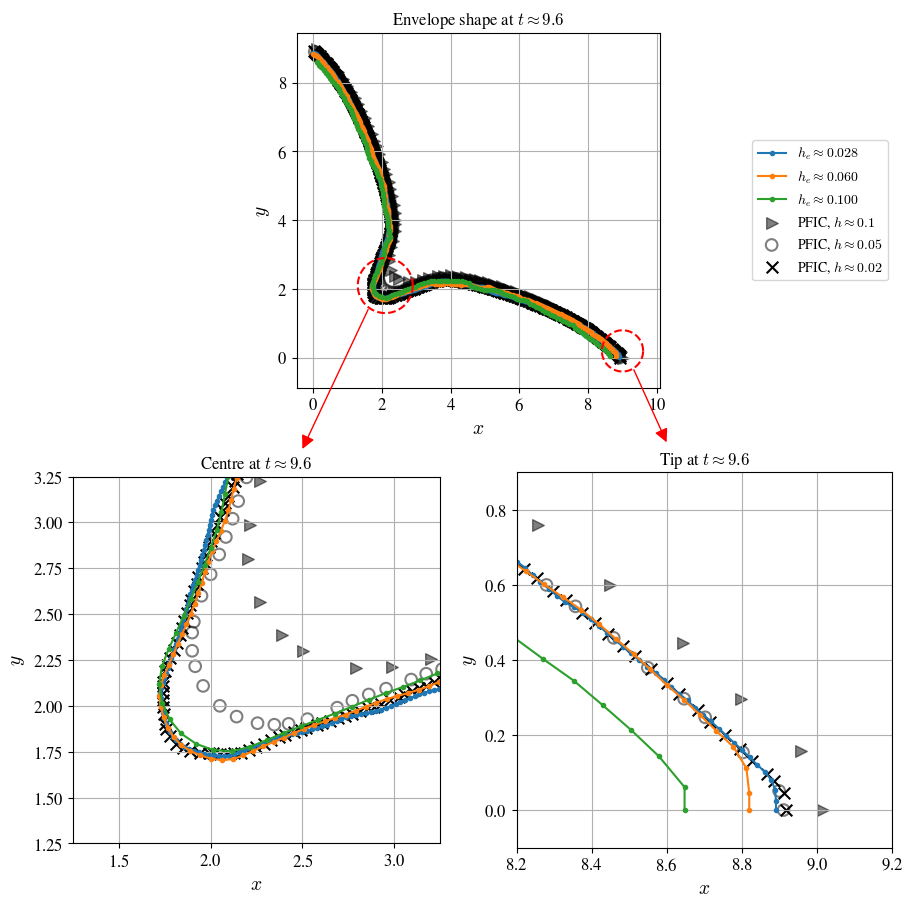

In [28]:
fig = plt.figure(figsize=(9, 9), layout="constrained")
spec = fig.add_gridspec(2, 4)

# Entire dendrite.
ax0 = fig.add_subplot(spec[0, 1:3])
ax0l = fig.add_subplot(spec[0, 3])
ax0l.set_axis_off()

# Centre dendrite.
ax10 = fig.add_subplot(spec[1, 0:2])

# Dendrite tip.
ax11 = fig.add_subplot(spec[1, 2:4])

n = len(hs)
# colors = plt.cm.jet_r(np.linspace(0, 1, n))

for h in [hs[0], hs[9], hs[-1]]:
    for source_file in source_files:
        data = h5.File(source_file, 'r')

        if (data['conf'].attrs.get('domain.dendrite.h') != h):
            data.close()
            continue

        # Get groups.
        groups = list(data.keys())
        positions = []
        solutions = []
        velocities = []
        tip_velocities = []
        times = []
        types = []
        for group in groups:
            if "step" not in group:
                continue

            positions.append(data[group]['domain']['pos'][:])
            solutions.append(data[group]['solution'][:])
            tip_velocities.append(data[group]['tip_velocities'][:])
            velocities.append(data[group].attrs['max_tip_velocity'])
            times.append(data[group].attrs['time'])
            types.append(data[group]['domain']['types'][:])

        # Set timestep.
        time = 9.6
        closest_time = min(times, key=lambda x: abs(x-time))
        idx = times.index(closest_time)
        positions = positions[idx]

        # Extract only dendrite boundary. Only one quarter please.
        envelope_position_idx = list([i for i in range(len(
            types[idx])) if types[idx][i] == -2 and positions[0][i] >= 0 and positions[1][i] >= 0])
        envelope_positions = positions[:, envelope_position_idx]
        envelope_positions = envelope_positions.transpose()
        envelope_positions = find_nearest(
            envelope_positions, np.array([-1, 7]))
        envelope_positions = list(envelope_positions)
        envelope_positions = np.array([p for p in envelope_positions])
        envelope_positions = envelope_positions.transpose()
        # Conf.
        dendrite_h = data['conf'].attrs.get('domain.dendrite.h')
        liquid_h = data['conf'].attrs.get('domain.liquid.h')

        # Close.
        data.close()

        ax0.plot(envelope_positions[0], envelope_positions[1], '.-', label=r'$h_e\approx{:.3f}$'.format(
            dendrite_h))
        ax10.plot(envelope_positions[0], envelope_positions[1], '.-', label=r'$h_e\approx{:.3f}$'.format(
            dendrite_h))
        e_1 = np.append(envelope_positions[0], envelope_positions[0][-1])
        e_2 = np.append(envelope_positions[1], 0)
        ax11.plot(e_1, e_2, '.-', label=r'$h_e\approx{:.3f}$'.format(
            dendrite_h))

        # FVM solutions.
        if (h == hs[-1]):
            files = ['../data/FVM/surfaces/Eqx2D_Om0p18_G2_d1.0_m0.1/postProcessing/surfaces/9.6/alpha1_interpolatedIso.raw',
                     '../data/FVM/surfaces/Eqx2D_Om0p18_G2_d1.0_m0.05/postProcessing/surfaces/9.6/alpha1_interpolatedIso.raw',
                    '../data/FVM/surfaces/Eqx2D_Om0p18_G2_d1.0_m0.01953125/postProcessing/surfaces/9.6/alpha1_interpolatedIso.raw']
            markers =['>', '.', 'x']
            for marker_id, file in enumerate(files):
                with open(file) as f:
                    lines = f.readlines()

                #  Parse data from file.
                x = []
                y = []
                for line in lines[2:]:
                    val = line.strip().split(' ')
                    x.append(float(val[0]))
                    y.append(float(val[1]))

                x, y = order_points(np.array([x, y]))

                if (markers[marker_id] == "."):
                    ax0.scatter( x[::20], y[::20], color='k', facecolors='none', edgecolors='k', s=70, alpha=1 if markers[marker_id] == "x" else 0.5, label = r'PFIC, $h\approx{}$'.format(round(float(file.split('_m')[-1].split('/')[0]), 3)),linewidths=1.5)
                    ax10.scatter(x[::20], y[::20], color='k', facecolors='none', edgecolors='k', s=70, alpha=1 if markers[marker_id] == "x" else 0.5, label = r'PFIC, $h\approx{}$'.format(round(float(file.split('_m')[-1].split('/')[0]), 3)),linewidths=1.5)
                    ax11.scatter(x[::20], y[::20], color='k', facecolors='none', edgecolors='k', s=70, alpha=1 if markers[marker_id] == "x" else 0.5, label = r'PFIC, $h\approx{}$'.format(round(float(file.split('_m')[-1].split('/')[0]), 3)),linewidths=1.5)
                else:
                    ax0.scatter( x[::20], y[::20], color='k', marker = markers[marker_id], s=70, alpha=1 if markers[marker_id] == "x" else 0.5, label = r'PFIC, $h\approx{}$'.format(round(float(file.split('_m')[-1].split('/')[0]), 3)))
                    ax10.scatter(x[::20], y[::20], color='k', marker = markers[marker_id], s=70, alpha=1 if markers[marker_id] == "x" else 0.5, label = r'PFIC, $h\approx{}$'.format(round(float(file.split('_m')[-1].split('/')[0]), 3)))
                    ax11.scatter(x[::20], y[::20], color='k', marker = markers[marker_id], s=70, alpha=1 if markers[marker_id] == "x" else 0.5, label = r'PFIC, $h\approx{}$'.format(round(float(file.split('_m')[-1].split('/')[0]), 3)))


ax0.set_title(r'Envelope shape at $t \approx {:.1f}$'.format(time))
ax0.set_xlabel("$x$")
ax0.set_ylabel("$y$")
ax0.grid("both")
ax0.set_aspect('equal')
h, l = ax0.get_legend_handles_labels()
ax0l.legend(h,l, loc='center')

ax10.set_xlabel("$x$")
ax10.set_ylabel("$y$")
ax10.set_title(r'Centre at $t \approx {:.1f}$'.format(time))
ax10.grid("both")
ax10.set_xlim(left=1.25, right=3.25)
ax10.set_ylim(bottom=1.25, top=3.25)
ax10.set_aspect('equal')
# ax10.add_patch(
#         patches.Polygon(np.array([[2.4, 1.6], [2.4,1.79], [3.1,1.79], [3.1,1.6]]), ec='red', fill=False, alpha=1, linestyle='--',linewidth=1.5)
#     )  # not sticky

ax11.set_title(r'Tip at $t \approx {:.1f}$'.format(time))
ax11.set_xlabel("$x$")
ax11.set_ylabel("$y$")
ax11.grid("both")
ax11.set_xlim(left=8.2, right=9.2)
ax11.set_ylim(bottom=-0.1, top=0.9)
ax11.set_aspect('equal')

# Helper plots.
r = 0.8
x0 = 2.1
y0 = 2.1
x = x0 + r * np.cos(np.linspace(0, 2 * np.pi, 1000))
y = y0 + r * np.sin(np.linspace(0, 2 * np.pi, 1000))
ax0.plot(x, y, '--r')

r = 0.6
x0 = 9
y0 = 0.2
x = x0 + r * np.cos(np.linspace(0, 2 * np.pi, 1000))
y = y0 + r * np.sin(np.linspace(0, 2 * np.pi, 1000))
ax0.plot(x, y, '--r')

# Subplot arrows.
xyA = [1.6, 1.4]
xyB = [2.5, 3.4]
arrow = patches.ConnectionPatch(
    xyA,
    xyB,
    coordsA=ax0.transData,
    coordsB=ax10.transData,
    # Default shrink parameter is 0 so can be omitted
    color="red",
    arrowstyle="-|>",  # "normal" arrow
    mutation_scale=20,  # controls arrow head size
    linewidth=1,
)
fig.patches.append(arrow)

xyA = [9.33, -0.35]
xyB = [8.6, 0.98]
arrow = patches.ConnectionPatch(
    xyA,
    xyB,
    coordsA=ax0.transData,
    coordsB=ax11.transData,
    # Default shrink parameter is 0 so can be omitted
    color="red",
    arrowstyle="-|>",  # "normal" arrow
    mutation_scale=20,  # controls arrow head size
    linewidth=1,
)
fig.patches.append(arrow)

if 1:
    fig.savefig('../manuscript/paper/figures/convergence_envelope_shape.eps', dpi=300, transparent=False, bbox_inches='tight')

# Max tip position as function of time

DENDRITE h 0.028013567611988685
DENDRITE h 0.028013567611988685


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


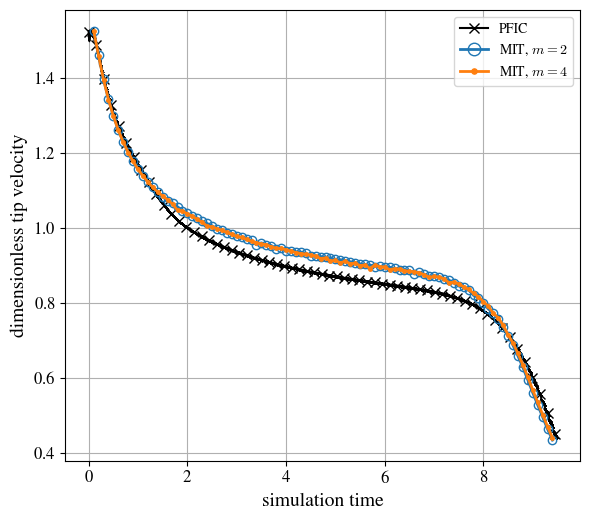

In [14]:
fig = plt.figure(figsize=(6, 5.3),tight_layout=True)
gs = gridspec.GridSpec(1, 2)

# PLot velocity vs tip position
ax = fig.add_subplot(gs[0,:])
p, = ax.plot(fvm_times[:len(fvm_times) - 69000], fvm_tip_velocities[:len(fvm_tip_positions) - 69000], 'x-', ms = 5, lw=1.5, alpha=1, color='k', label=r"PFIC")
handle, label = ax.get_legend_handles_labels()
p.remove()
p, = ax.plot(fvm_times[:len(fvm_times) - 69000], fvm_tip_velocities[:len(fvm_tip_positions) - 69000], 'x-', ms = 0.5, lw=1.5, alpha=1, color='k')
ax.plot(fvm_times[:len(fvm_times) - 69000][::1000], fvm_tip_velocities[:len(fvm_tip_positions) - 69000][::1000], 'x', ms = 7, lw=0.1, alpha=1, color='k')
# lin, = ax.plot(miha_data['xTip'], miha_data['Vtip d1.0 Dx0.05'], label="FVM", color='k', alpha=0.1)
# mark, = ax.plot(miha_data['xTip'], miha_data['Vtip d1.0 Dx0.05'], marker='.', color='k', label="FVM", alpha=0.1)


for source_file in ['../data/spline2/spline2_results_000015.h5', '../data/high_order/spline2_mon_4_results_000015.h5']:
    data = h5.File(source_file, 'r')

    # Get groups.
    groups = list(data.keys())
    positions = []
    velocities = []
    times = []
    types = []
    for group in groups:
        if "step" not in group:
            continue

        positions.append(data[group]['domain']['pos'][:])
        velocities.append(data[group].attrs['max_tip_velocity'])
        times.append(data[group].attrs['time'])
        types.append(data[group]['domain']['types'][:])

    # Get conf.
    conf = data['conf']
    dendrite_h = conf.attrs.get('domain.dendrite.h')
    print("DENDRITE h", dendrite_h)
    liquid_h = conf.attrs.get('domain.liquid.h')
    L = conf.attrs.get("domain.liquid.size")

    # Close file.
    data.close()

    # Plot.
    rel = [max(max(pos[0][typ == -2]), max(pos[1][typ == -2]))
            for pos, typ in zip(positions, types)]
    N_envelope = len(positions[-1][0][types[-1] == -2])
    if "mon_4" in source_file:
        ax.plot(times[1:], velocities[1:], '.-', label="MIT, $m=4$", lw=2, ms=5)
    else:
        ax.plot(times[1:], velocities[1:], '-', label="MIT, $m=2$", lw=2, marker='o', fillstyle='none')

ax.set_xlabel(r'simulation time')
ax.set_ylabel("dimensionless tip velocity")
ax.grid("both")
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles = handle + handles, labels = label + labels, markerscale=1.5)
#change the marker size manually for both lines

fig.tight_layout()
if 1:
    fig.savefig('../manuscript/paper/figures/convergence_max_tip_vs_number_of_nodes.eps', dpi=300, transparent=False, bbox_inches='tight')


# Tip position convergence

Reading:  ../data/spline2/spline2_results_000001.h5
Reading:  ../data/spline2/spline2_results_000000.h5
Reading:  ../data/spline2/spline2_results_000011.h5
Reading:  ../data/spline2/spline2_results_000006.h5
Reading:  ../data/spline2/spline2_results_000016.h5
Reading:  ../data/spline2/spline2_results_000009.h5
Reading:  ../data/spline2/spline2_results_000007.h5
Reading:  ../data/spline2/spline2_results_000002.h5
Reading:  ../data/spline2/spline2_results_000003.h5
Reading:  ../data/spline2/spline2_results_000005.h5
Reading:  ../data/spline2/spline2_results_000004.h5
Reading:  ../data/spline2/spline2_results_000015.h5
Reading:  ../data/spline2/spline2_results_000014.h5
Reading:  ../data/spline2/spline2_results_000008.h5
Reading:  ../data/spline2/spline2_results_000010.h5
Reading:  ../data/spline2/spline2_results_000013.h5
Reading:  ../data/spline2/spline2_results_000012.h5
[5.9489]
Reading:  ../data/high_order/spline2_mon_4_results_000005.h5
Reading:  ../data/high_order/spline2_mon_4_res

/tmp/ipykernel_42699/4124315194.py:188: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


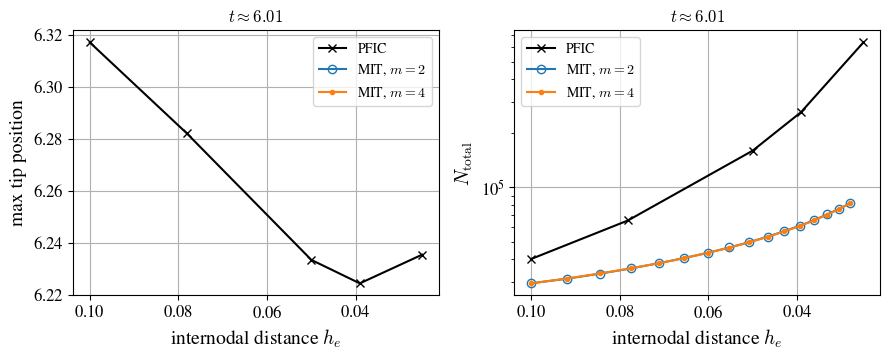

In [32]:
fig = plt.figure(figsize=(9, 3.7),tight_layout=True)
gs = gridspec.GridSpec(1, 2)

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

min_time = np.min(simulation_times)
max_time = np.max(simulation_times)
avg_time = (max_time + min_time) * 0.5
times_sim = 7.5


files = [glob.glob("../data/spline2/spline2_results_*.h5"), glob.glob("../data/high_order/spline2_mon_4_*.h5")]

for id, source_files in enumerate(files):

    hs = []
    simulation_times = []
    for source_file in source_files:
        print("Reading: ", source_file)
        data = h5.File(source_file, 'r')
        hs.append(data['conf'].attrs.get('domain.dendrite.h'))
        groups = list(data.keys())
        for group in groups:
            if "step" not in group:
                continue
            simulation_times.append(data[group].attrs['time'])
        data.close()

    hs = sorted(hs)


    min_time = np.min(simulation_times)
    max_time = np.max(simulation_times)
    avg_time = (max_time + min_time) * 0.5
    times_sim = [max_time * 0.589]

    data_p = {}

    for source_file in source_files:
        data = h5.File(source_file, 'r')

        # Get groups.
        groups = list(data.keys())
        positions = []
        velocities = []
        times = []
        types = []
        for group in groups:
            if "step" not in group:
                continue

            positions.append(data[group]['domain']['pos'][:])
            velocities.append(data[group].attrs['max_tip_velocity'])
            times.append(data[group].attrs['time'])
            types.append(data[group]['domain']['types'][:])

        # Conf.
        dendrite_h = data['conf'].attrs.get('domain.dendrite.h')

        # Close.
        data.close()

        # Set time step.
        for time in times_sim:
            temp_data = {}
            closest_time = min(times, key=lambda x: abs(x-time))
            idx = times.index(closest_time)
            pos = positions[idx]

            # Extract only dendrite boundary. Only one quarter please.
            envelope_position_idx = [i for i in range(len(types[idx])) if (
                types[idx][i] == -2)]
            envelope_positions = pos[:, envelope_position_idx]

            temp_data['max_position'] = np.max(envelope_positions)
            temp_data['goal_time'] = time
            temp_data['closest_time'] = closest_time
            temp_data['N_envelope'] = len(envelope_positions[0])
            temp_data['N_total'] = len(pos[0])
            temp_data['h'] = dendrite_h
            data_p['{}_{}'.format(source_file, time)] = temp_data

    times = [data_p[id]['goal_time'] for id in data_p]
    unique_times = np.unique(times)
    print(unique_times)
    fvm_times = ['6']


    # FVM
    files = glob.glob('../data/FVM/surfaces/*' + os.path.sep)
    max_fvm_pos = []
    fvm_hs = []
    fvm_total_nodes = []
    for time in fvm_times:
        max_pos = []
        temp_hs = []
        nodes = []
        for file in files[:-1]:
            temp_hs.append(float(file.split('_m')[-1].split('/')[0]))
            filepath = '{}postProcessing/surfaces/{}/alpha1_interpolatedIso.raw'.format(file,time)
            with open(filepath) as f:
                lines = f.readlines()

            #  Parse data from file.
            x = []
            y = []
            for line in lines[2:]:
                val = line.strip().split(' ')
                x.append(float(val[0]))
                y.append(float(val[1]))
            max_pos.append(max(np.max(x), np.max(y)))
            nodes.append(len(x))

        max_fvm_pos.append(max_pos)
        fvm_hs.append(temp_hs)
        fvm_total_nodes.append(nodes)

    #############
    # PLot
    ############
    ax0.set_title(r'$t \approx {:.2f}$'.format(unique_times[0]))

    for color_id, time in enumerate(unique_times):
        # FVM
        if (id == 0):
            fvm_x, fvm_y = zip(*sorted(zip(fvm_hs[color_id], max_fvm_pos[color_id])))
            ax0.plot(fvm_x[:-2], fvm_y[:-2], 'x-k', label='PFIC')

            ax0.invert_xaxis()
            ax0.set_xlabel('internodal distance $h_e$')
        
        nodes = [data_p[id]['N_envelope']
                for id in data_p if (data_p[id]['goal_time'] == time)]
        max_positions = [data_p[id]['max_position']
                        for id in data_p if (data_p[id]['goal_time'] == time)]
        internodal_distances = [data_p[id]['h']
                                for id in data_p if (data_p[id]['goal_time'] == time)]

        # sort by nodes.
        _, max_positions = zip(*sorted(zip(nodes, max_positions)))
        nodes, internodal_distances = zip(
            *sorted(zip(nodes, internodal_distances)))

        internodal_distances = [internodal_distances[i] for i in range(len(internodal_distances)) if max_positions[i] > 8]
        max_positions = [x for x in max_positions if x > 8]
        if id == 0:
            ax0.plot(internodal_distances[:-1], max_positions[:-1], '-', label="MIT," + (" $m=2$" if id == 0 else " $m=4$"),  marker='o', fillstyle='none')
        else:
            ax0.plot(internodal_distances, max_positions, '.-', label="MIT," + (" $m=2$" if id == 0 else " $m=4$"))

        ax0.grid(True)
        ax0.set_xlabel('internodal distance $h_e$')
        ax0.set_ylabel("max tip position")
        ax0.legend()

    # TOTAL NODES
    ax1.set_title(r'$t \approx {:.2f}$'.format(unique_times[0]))

    for color_id, time in enumerate(unique_times):
        # FVM
        if id == 0:
            fvm_x, fvm_y = zip(*sorted(zip(fvm_hs[color_id],[(20/x)**2 for x in fvm_hs[color_id]] )))
            ax1.semilogy(fvm_x[:-2], fvm_y[:-2], 'x-k', label='PFIC')

            ax1.invert_xaxis()
        nodes_tot = [data_p[id]['N_total']
                for id in data_p if (data_p[id]['goal_time'] == time)]
        internodal_distances = [data_p[id]['h']
                                for id in data_p if (data_p[id]['goal_time'] == time)]

        # sort by nodes.
        internodal_distances, nodes_tot = zip(*sorted(zip(internodal_distances, nodes_tot)))

        if id == 0:
            ax1.semilogy(internodal_distances[-16:], nodes_tot[-16:], '-',label="MIT," + (" $m=2$" if id == 0 else " $m=4$"),  marker='o', fillstyle='none')
        else:
            ax1.semilogy(internodal_distances[-16:], nodes_tot[-16:], '.-', label="MIT," + (" $m=2$" if id == 0 else " $m=4$"))

        ax1.grid(True)
        ax1.set_xlabel('internodal distance $h_e$')
        ax1.set_ylabel('$N_\mathrm{total}$')
        ax1.legend(loc='upper left')

    # fig.suptitle(
    #     r"max. tip position vs. number of nodes on envelope (for times closest to $t^\star$)")

    fig.tight_layout()
if 0:
    fig.savefig('../manuscript/paper/figures/max_tip_vs_number_of_nodes.eps', dpi=300, transparent=False, bbox_inches='tight')

# Estimate waveiness by computing curvature length

In [33]:
def order_points(positions):
    # Sort points.
    angles = np.arctan2(positions[1], positions[0])
    idx = np.argsort(angles)

    pos = positions[:,idx]

    return pos

In [34]:
files = [glob.glob("../data/spline2/spline2_results_*.h5"), glob.glob("../data/high_order/spline2_mon_4_*.h5")]
files

[['../data/spline2/spline2_results_000001.h5',
  '../data/spline2/spline2_results_000000.h5',
  '../data/spline2/spline2_results_000011.h5',
  '../data/spline2/spline2_results_000006.h5',
  '../data/spline2/spline2_results_000016.h5',
  '../data/spline2/spline2_results_000009.h5',
  '../data/spline2/spline2_results_000007.h5',
  '../data/spline2/spline2_results_000002.h5',
  '../data/spline2/spline2_results_000003.h5',
  '../data/spline2/spline2_results_000005.h5',
  '../data/spline2/spline2_results_000004.h5',
  '../data/spline2/spline2_results_000015.h5',
  '../data/spline2/spline2_results_000014.h5',
  '../data/spline2/spline2_results_000008.h5',
  '../data/spline2/spline2_results_000010.h5',
  '../data/spline2/spline2_results_000013.h5',
  '../data/spline2/spline2_results_000012.h5'],
 ['../data/high_order/spline2_mon_4_results_000005.h5',
  '../data/high_order/spline2_mon_4_results_000011.h5',
  '../data/high_order/spline2_mon_4_results_000013.h5',
  '../data/high_order/spline2_mo

0.6
7.3
0.6
7.3


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


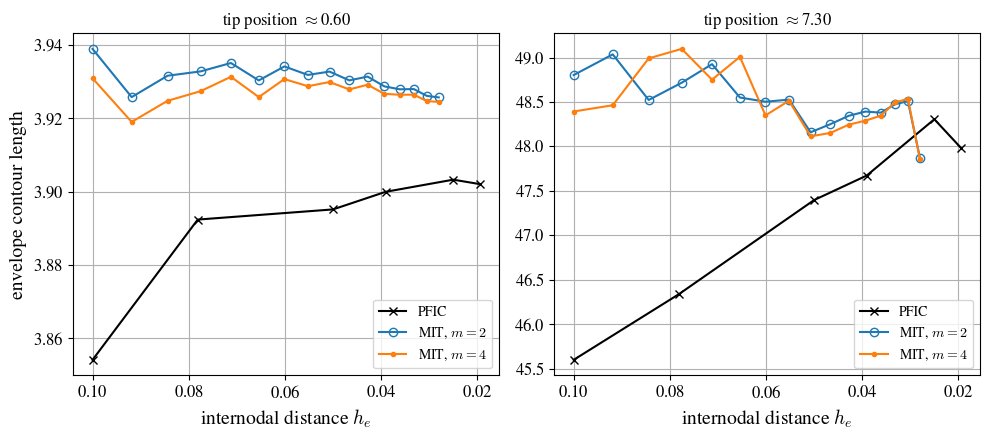

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4.5))

for id, source_files in enumerate(files):
    warnings.filterwarnings("ignore")

    tip_positions = [0.6, 7.3]

    data_p = {}

    for source_file in source_files:
        data = h5.File(source_file, 'r')

        # Get groups.
        groups = list(data.keys())
        positions = []
        velocities = []
        times = []
        types = []
        for group in groups:
            if "step" not in group:
                continue

            positions.append(data[group]['domain']['pos'][:])
            velocities.append(data[group].attrs['max_tip_velocity'])
            times.append(data[group].attrs['time'])
            types.append(data[group]['domain']['types'][:])

        # Conf.
        dendrite_h = data['conf'].attrs.get('domain.dendrite.h')

        # Close.
        data.close()

        # Max tip positions.
        max_positions = [np.max(pos[:, types[i] == -2]) for i, pos in enumerate(positions)]

        # Set time step.
        for tip_position in tip_positions:
            closest_tip_position = min(max_positions, key=lambda x: abs(x-tip_position))
            idx = max_positions.index(closest_tip_position)
            pos = positions[idx]

            # Extract only dendrite boundary. Only one quarter please.
            envelope_position_idx = [i for i in range(len(types[idx])) if (types[idx][i] == -2)]
            envelope_positions = pos[:, envelope_position_idx]

            # Sort points.
            phis = np.arctan2(envelope_positions[1], envelope_positions[0])
            idx = np.argsort(phis)
            envelope_positions = envelope_positions[:,idx]
            # Fit spline.
            x = envelope_positions[0]
            y = envelope_positions[1]

            # fit splines to x=f(u) and y=g(u), treating both as periodic. also note that s=0
            # is needed in order to force the spline fit to pass through all the input points.
            # tck, u = interpolate.splprep([x, y], per=True, s=0)
            tck, u = interpolate.splprep([x, y], s=0, per=True, quiet=1)

            # evaluate the spline fits for 5000 evenly spaced distance values
            xi, yi = interpolate.splev(np.linspace(0, 1, 5000), tck)

            total_length = 0
            for i in range(len(xi) - 1):
                dx = xi[i+1] - xi[i]
                dy = yi[i+1] - yi[i]
                total_length += np.sqrt(dx*dx + dy*dy)
            dx = xi[-1] - xi[0]
            dy = yi[-1] - yi[0]
            total_length += np.sqrt(dx*dx + dy*dy)

            temp_data = {}
            temp_data['envelope_length'] = total_length
            temp_data['goal_position'] = tip_position
            temp_data['closest_tip_position'] = closest_tip_position
            temp_data['N_envelope'] = len(envelope_positions[0])
            temp_data['h'] = dendrite_h
            data_p['{}_{}'.format(source_file, tip_position)] = temp_data

    # FVM data


    data_fvm = {}

    fvm_discretizations = glob.glob('../data/FVM/surfaces/*' + os.path.sep)

    # Set time step.
    for tip_position in tip_positions:
        tip_position_data = []

        for fvm_discretization in fvm_discretizations:
            temp_data = {}
            times = glob.glob('{}postProcessing/surfaces/*'.format(fvm_discretization), recursive=True)
            # Find best time for given tip position.
            diff = 1e6
            for filepath in times:
                with open('{}/alpha1_interpolatedIso.raw'.format(filepath)) as f:
                    lines = f.readlines()

                #  Parse data from file.
                x = []
                y = []
                for line in lines[2:]:
                    val = line.strip().split(' ')
                    x.append(float(val[0]))
                    y.append(float(val[1]))
                    
                if (abs(max(np.max(x), np.max(y)) - tip_position)) < diff:
                    diff = abs(max(np.max(x), np.max(y)) - tip_position)
                    temp_data['diff'] = diff
                    temp_data['file'] = '{}/alpha1_interpolatedIso.raw'.format(filepath)
                    temp_data['x'] = x
                    temp_data['y'] = y
            
            # Save best time step.
            tip_position_data.append(temp_data)


        data_fvm[tip_position] = tip_position_data
            
    fvm_plot_data = {}
    for tip_position in tip_positions:
        print(tip_position)
        data = data_fvm[tip_position]

        for discretization in data:
            x = np.array(discretization['x'] + list(np.array(discretization['x']) * (-1)) + list(np.array(discretization['x']) * (-1)) + discretization['x']  )
            y = np.array(discretization['y'] + discretization['y'] + list(np.array(discretization['y']) * (-1)) + list(np.array(discretization['y']) * (-1)) )

            envelope_positions = np.unique(np.vstack([x, y]), axis=1)
            phis = np.arctan2(envelope_positions[1], envelope_positions[0])
            idx = np.argsort(phis)
            envelope_positions = envelope_positions[:,idx]
            # Fit spline.
            x = envelope_positions[0][::5]
            y = envelope_positions[1][::5]
            # fit splines to x=f(u) and y=g(u), treating both as periodic. also note that s=0
            # is needed in order to force the spline fit to pass through all the input points.
            # tck, u = interpolate.splprep([x, y], per=True, s=0)
            tck, u = interpolate.splprep([x, y], s=0, per=True, quiet=1)

            # evaluate the spline fits for 5000 evenly spaced distance values
            xi, yi = interpolate.splev(np.linspace(0, 1, 5000), tck)

            total_length = 0
            for i in range(len(xi) - 1):
                dx = xi[i+1] - xi[i]
                dy = yi[i+1] - yi[i]
                total_length += np.sqrt(dx*dx + dy*dy)
            dx = xi[-1] - xi[0]
            dy = yi[-1] - yi[0]
            total_length += np.sqrt(dx*dx + dy*dy)

            temp_data = {}
            temp_data['envelope_length'] = total_length
            temp_data['goal_position'] = tip_position
            temp_data['closest_tip_position'] = max(np.max(x), np.max(y))
            temp_data['h'] = float(discretization['file'].split('_m')[-1].split('/')[0])
            fvm_plot_data['{}_{}'.format(discretization['file'], tip_position)] = temp_data
    warnings.filterwarnings("default")

    ##################
    #### PLOT
    ###################
    tip_positions = [data_p[id]['goal_position'] for id in data_p]
    unique_tip_positions  = np.unique(tip_positions )
    colors = plt.cm.jet_r(np.linspace(0, 1, len(unique_tip_positions)))

    for axs_id, tip_position in enumerate(unique_tip_positions):
        lengths = [data_p[id]['envelope_length'] for id in data_p if (data_p[id]['goal_position'] == tip_position)]
        internodal_distances = [data_p[id]['h'] for id in data_p if (data_p[id]['goal_position'] == tip_position)]

        # sort by nodes.
        ax = axs[axs_id]
        internodal_distances, lengths = zip(*sorted(zip(internodal_distances, lengths)))

        ax.set_title(r'tip position $\approx ${:.2f}'.format(tip_position))
        ax.grid(True)
        ax.set_xlabel('internodal distance $h_e$')
        
        if id == 0:
            fvm_h = [fvm_plot_data[d]['h'] for d in fvm_plot_data if (fvm_plot_data[d]['goal_position'] == tip_position)]
            fvm_lengths = [fvm_plot_data[d]['envelope_length'] for d in fvm_plot_data if (fvm_plot_data[d]['goal_position'] == tip_position)]
            fvm_h, fvm_lengths = zip(*sorted(zip(fvm_h, fvm_lengths)))
            ax.plot(fvm_h[:-2], fvm_lengths[:-2], 'kx-', label="PFIC")
        if id == 0:
            ax.plot(internodal_distances[-16:], lengths[-16:], '-', label = "MIT," + (" $m=2$" if id == 0 else " $m=4$"), marker='o', fillstyle='none')
        else:
            ax.plot(internodal_distances, lengths, '.-', label = "MIT," + (" $m=2$" if id == 0 else " $m=4$"))

        if id == 0:
            ax.invert_xaxis()
        if id == 1:
            ax.legend()

axs[0].set_ylabel("envelope contour length")

fig.tight_layout()

if 1:
    fig.savefig('../manuscript/paper/figures/convergence_contour_length.eps', dpi=300, transparent=False, bbox_inches='tight')

# Tip position (left) and waviness(right)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


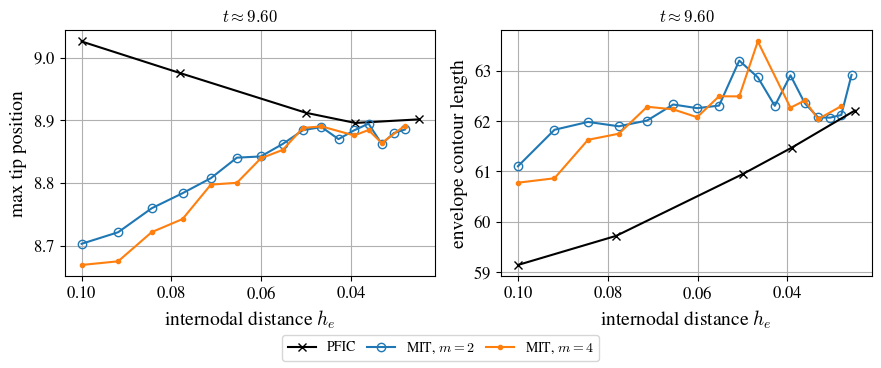

In [81]:
fig, axs= plt.subplots(1, 2, figsize=(9, 3.7))

files = [glob.glob("../data/spline2/spline2_results_*.h5"), glob.glob("../data/high_order/spline2_mon_4_*.h5")]

for id, source_files in enumerate(files):

    hs = []
    simulation_times = []
    for source_file in source_files:
        data = h5.File(source_file, 'r')
        hs.append(data['conf'].attrs.get('domain.dendrite.h'))
        groups = list(data.keys())
        for group in groups:
            if "step" not in group:
                continue
            simulation_times.append(data[group].attrs['time'])
        data.close()

    hs = sorted(hs)

    times_sim = [9.6]

    data_p = {}

    for source_file in source_files:
        data = h5.File(source_file, 'r')

        # Get groups.
        groups = list(data.keys())
        positions = []
        velocities = []
        times = []
        types = []
        for group in groups:
            if "step" not in group:
                continue

            positions.append(data[group]['domain']['pos'][:])
            velocities.append(data[group].attrs['max_tip_velocity'])
            times.append(data[group].attrs['time'])
            types.append(data[group]['domain']['types'][:])

        # Conf.
        dendrite_h = data['conf'].attrs.get('domain.dendrite.h')

        # Close.
        data.close()

        # Set time step.
        for time in times_sim:
            temp_data = {}
            closest_time = min(times, key=lambda x: abs(x-time))
            idx = times.index(closest_time)
            pos = positions[idx]

            # Extract only dendrite boundary. Only one quarter please.
            envelope_position_idx = [i for i in range(len(types[idx])) if (
                types[idx][i] == -2)]
            envelope_positions = pos[:, envelope_position_idx]
            if np.max(envelope_positions) < 8.6:
                continue
            temp_data['max_position'] = np.max(envelope_positions)
            temp_data['goal_time'] = time
            temp_data['closest_time'] = closest_time
            temp_data['N_envelope'] = len(envelope_positions[0])
            temp_data['N_total'] = len(pos[0])
            temp_data['h'] = dendrite_h
            data_p['{}_{}'.format(source_file, time)] = temp_data

    times = [data_p[id]['goal_time'] for id in data_p]
    unique_times = np.unique(times)
    
    fvm_times = [str(times_sim[0])]


    # FVM
    files = glob.glob('../data/FVM/surfaces/*' + os.path.sep)
    max_fvm_pos = []
    fvm_hs = []
    for time in fvm_times:
        max_pos = []
        temp_hs = []
        nodes = []
        for file in files[:-1]:
            temp_hs.append(float(file.split('_m')[-1].split('/')[0]))
            filepath = '{}postProcessing/surfaces/{}/alpha1_interpolatedIso.raw'.format(file,time)
            with open(filepath) as f:
                lines = f.readlines()

            #  Parse data from file.
            x = []
            y = []
            for line in lines[2:]:
                val = line.strip().split(' ')
                x.append(float(val[0]))
                y.append(float(val[1]))
            max_pos.append(max(np.max(x), np.max(y)))

        max_fvm_pos.append(max_pos)
        fvm_hs.append(temp_hs)

    #############
    # PLot
    ############
    axs[0].set_title(r'$t \approx {:.2f}$'.format(unique_times[0]))

    for color_id, time in enumerate(unique_times):
        # FVM
        if (id == 0):
            fvm_x, fvm_y = zip(*sorted(zip(fvm_hs[color_id], max_fvm_pos[color_id])))
            axs[0].plot(fvm_x[:-2], fvm_y[:-2], 'x-k', label='PFIC')

            axs[0].invert_xaxis()
            axs[0].set_xlabel('internodal distance $h_e$')
        
        nodes = [data_p[id]['N_envelope']
                for id in data_p if (data_p[id]['goal_time'] == time)]
        max_positions = [data_p[id]['max_position']
                        for id in data_p if (data_p[id]['goal_time'] == time)]
        internodal_distances = [data_p[id]['h']
                                for id in data_p if (data_p[id]['goal_time'] == time)]

        # sort by nodes.
        _, max_positions = zip(*sorted(zip(nodes, max_positions)))
        nodes, internodal_distances = zip(
            *sorted(zip(nodes, internodal_distances)))

        internodal_distances = [internodal_distances[i] for i in range(len(internodal_distances)) if max_positions[i] > 6]
        max_positions = [x for x in max_positions if x > 6]
        if id == 0:
            axs[0].plot(internodal_distances[:-1], max_positions[:-1], '-', label="MIT," + (" $m=2$" if id == 0 else " $m=4$"),  marker='o', fillstyle='none')
        else:
            axs[0].plot(internodal_distances, max_positions, '.-', label="MIT," + (" $m=2$" if id == 0 else " $m=4$"))

        axs[0].grid(True)
        axs[0].set_xlabel('internodal distance $h_e$')
        axs[0].set_ylabel("max tip position")
        # axs[0].legend()
        

# **************
# RIGHT PLOT
# **************

files = [glob.glob("../data/spline2/spline2_results_*.h5"), glob.glob("../data/high_order/spline2_mon_4_*.h5")]

for id, source_files in enumerate(files):
    warnings.filterwarnings("ignore")

    plot_times = times_sim

    data_p = {}

    for source_file in source_files:
        data = h5.File(source_file, 'r')

        # Get groups.
        groups = list(data.keys())
        positions = []
        velocities = []
        times = []
        types = []
        for group in groups:
            if "step" not in group:
                continue

            positions.append(data[group]['domain']['pos'][:])
            velocities.append(data[group].attrs['max_tip_velocity'])
            times.append(data[group].attrs['time'])
            types.append(data[group]['domain']['types'][:])

        # Conf.
        dendrite_h = data['conf'].attrs.get('domain.dendrite.h')

        # Close.
        data.close()

        # Max tip positions.

        # Set time step.
        for time in plot_times:
            closest_time = min(times, key=lambda x: abs(x-time))
            idx = times.index(closest_time)
            pos = positions[idx]
            # Extract only dendrite boundary. Only one quarter please.
            envelope_position_idx = [i for i in range(len(types[idx])) if (types[idx][i] == -2)]
            envelope_positions = pos[:, envelope_position_idx]
            # Sort points.
            phis = np.arctan2(envelope_positions[1], envelope_positions[0])
            idx = np.argsort(phis)
            envelope_positions = envelope_positions[:,idx]
            # Fit spline.
            x = envelope_positions[0]
            y = envelope_positions[1]
            # fit splines to x=f(u) and y=g(u), treating both as periodic. also note that s=0
            # is needed in order to force the spline fit to pass through all the input points.
            # tck, u = interpolate.splprep([x, y], per=True, s=0)
            tck, u = interpolate.splprep([x, y], s=0, per=True, quiet=1)

            # evaluate the spline fits for 5000 evenly spaced distance values
            xi, yi = interpolate.splev(np.linspace(0, 1, 5000), tck)

            total_length = 0
            for i in range(len(xi) - 1):
                dx = xi[i+1] - xi[i]
                dy = yi[i+1] - yi[i]
                total_length += np.sqrt(dx*dx + dy*dy)
            dx = xi[-1] - xi[0]
            dy = yi[-1] - yi[0]
            total_length += np.sqrt(dx*dx + dy*dy)

            temp_data = {}
            temp_data['envelope_length'] = total_length
            if (total_length < 57.5):
                continue
            temp_data['time'] = time
            temp_data['N_envelope'] = len(envelope_positions[0])
            temp_data['h'] = dendrite_h
            data_p['{}_{}'.format(source_file, tip_position)] = temp_data

    # FVM data
    # FVM
    data_fvm = {}
    files = glob.glob('../data/FVM/surfaces/*' + os.path.sep)
    max_fvm_pos = []
    fvm_hs = []
    for time in fvm_times:
        max_pos = []
        temp_hs = []
        nodes = []
        for file in files[:-1]:
            temp_hs.append(float(file.split('_m')[-1].split('/')[0]))
            filepath = '{}postProcessing/surfaces/{}/alpha1_interpolatedIso.raw'.format(file,time)
            with open(filepath) as f:
                lines = f.readlines()

            #  Parse data from file.
            x = []
            y = []
            for line in lines[2:]:
                val = line.strip().split(' ')
                x.append(float(val[0]))
                y.append(float(val[1]))
            max_pos.append(max(np.max(x), np.max(y)))

            temp_data = {}
            temp_data['x']=x
            temp_data['y']=y
            temp_data['tip']=max(np.max(y), np.max(x))
            temp_data['file']=file
            data_fvm[file] = temp_data

    fvm_plot_data = {}
    for file in data_fvm:
        case = data_fvm[file]
        x = np.array(case['x'] + list(np.array(case['x']) * (-1)) + list(np.array(case['x']) * (-1)) + case['x']  )
        y = np.array(case['y'] + case['y'] + list(np.array(case['y']) * (-1)) + list(np.array(case['y']) * (-1)) )

        envelope_positions = np.unique(np.vstack([x, y]), axis=1)
        phis = np.arctan2(envelope_positions[1], envelope_positions[0])
        idx = np.argsort(phis)
        envelope_positions = envelope_positions[:,idx]
        # Fit spline.
        x = envelope_positions[0][::5]
        y = envelope_positions[1][::5]
        # fit splines to x=f(u) and y=g(u), treating both as periodic. also note that s=0
        # is needed in order to force the spline fit to pass through all the input points.
        # tck, u = interpolate.splprep([x, y], per=True, s=0)
        tck, u = interpolate.splprep([x, y], s=0, per=True, quiet=1)

        # evaluate the spline fits for 5000 evenly spaced distance values
        xi, yi = interpolate.splev(np.linspace(0, 1, 5000), tck)

        total_length = 0
        for i in range(len(xi) - 1):
            dx = xi[i+1] - xi[i]
            dy = yi[i+1] - yi[i]
            total_length += np.sqrt(dx*dx + dy*dy)
        dx = xi[-1] - xi[0]
        dy = yi[-1] - yi[0]
        total_length += np.sqrt(dx*dx + dy*dy)

        temp_data = {}
        temp_data['envelope_length'] = total_length
        temp_data['h'] = float(file.split('_m')[-1].split('/')[0])
        fvm_plot_data['{}_{}'.format(file, tip_position)] = temp_data
    warnings.filterwarnings("default")

    ##################
    #### PLOT
    ###################
    axs[1].set_title(r'$t \approx {:.2f}$'.format(times_sim[0]))
    lengths = [data_p[file]['envelope_length'] for file in data_p]
    internodal = [data_p[file]['h'] for file in data_p]
    internodal, lengths = zip(*sorted(zip(internodal, lengths)))
    
    internodal = [internodal[i] for i in range(len(internodal)) if lengths[i] > 35]
    lengths = [lengths[i] for i in range(len(lengths)) if lengths[i] > 35]
    if id == 0:
        axs[1].plot(internodal, lengths, '-', label="MIT," + (" $m=2$" if id == 0 else " $m=4$"),  marker='o', fillstyle='none')
    else:
        axs[1].plot(internodal, lengths, '.-', label="MIT," + (" $m=2$" if id == 0 else " $m=4$"))

    if (id == 0):
        lengths = [fvm_plot_data[file]['envelope_length'] for file in fvm_plot_data]
        internodal = [fvm_plot_data[file]['h'] for file in fvm_plot_data]
        internodal, lengths = zip(*sorted(zip(internodal, lengths)))
        axs[1].plot(internodal[:-2], lengths[:-2], 'kx-', label="PFIC")

    axs[1].set_ylabel("envelope contour length")
    axs[1].grid(True, 'both')
    axs[1].set_xlabel('internodal distance $h_e$')
    if (id == 0):
        axs[1].invert_xaxis()


fig.tight_layout()

fig.subplots_adjust(bottom=0.24)   ##  Need to play with this number.
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(labels=labels, handles = handles, loc="lower center", ncol=3, columnspacing=0.8)

if 1:
    fig.savefig('../manuscript/paper/figures/position_and_envelope_length.eps', dpi=300, transparent=False, bbox_inches='tight')

# Computational times

In [17]:
source_files = glob.glob("../data/times/*.h5")
hs = []
simulation_times = []
for source_file in source_files:
    print("Reading: ", source_file)
    data = h5.File(source_file, 'r')
    hs.append(data['conf'].attrs.get('domain.dendrite.h'))
    groups = list(data.keys())
    for group in groups:
        if "step" not in group:
            continue
        simulation_times.append(data[group].attrs['time'])
    data.close()

hs = sorted(hs)

Reading:  ../data/times/results_000009.h5
Reading:  ../data/times/results_000010.h5
Reading:  ../data/times/results_000002.h5
Reading:  ../data/times/results_000001.h5
Reading:  ../data/times/results_000007.h5
Reading:  ../data/times/results_000011.h5
Reading:  ../data/times/results_000008.h5
Reading:  ../data/times/results_000005.h5
Reading:  ../data/times/results_000004.h5
Reading:  ../data/times/results_000014.h5
Reading:  ../data/times/results_000006.h5
Reading:  ../data/times/results_000013.h5
Reading:  ../data/times/results_000000.h5
Reading:  ../data/times/results_000012.h5
Reading:  ../data/times/results_000003.h5


In [18]:
with open('../data/FVM/ExecTimes.csv') as f:
    lines = f.readlines()

fvm_times = []
fvm_hs = []
for line in lines[1:]:
    data = line.strip().split(',')
    fvm_hs.append(float(data[0]))
    fvm_times.append(float(data[1]) / 3600 * 2)

/usr/lib/python3.10/_collections_abc.py:1158: MatplotlibDeprecationWarning: 
The modification of the Axes.lines property was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use Artist.remove() instead.
  del self[self.index(value)]


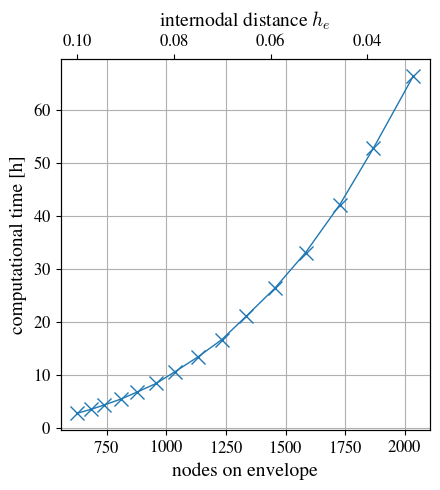

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(4.5, 5))

nodes = []
times = []
for h in hs:
    for source_file in source_files:
        data = h5.File(source_file, 'r')

        if (data['conf'].attrs.get('domain.dendrite.h') != h):
            data.close()
            continue

        # Get groups.
        groups = list(data.keys())
        group = groups[-1]
        positions = data[group]['domain']['pos'][:]
        time = data[group]['timer'].attrs.get('total') / 3600
        types = data[group]['domain']['types'][:]

        # Get conf.
        conf = data['conf']
        dendrite_h = conf.attrs.get('domain.dendrite.h')
        liquid_h = conf.attrs.get('domain.liquid.h')
        L = conf.attrs.get("domain.liquid.size")

        # Close file.
        data.close()

        # Plot.
        envelope = positions[:, types == -2]
        N_envelope = len(envelope[0])

        # Store data.
        nodes.append(N_envelope)
        times.append(time)

ax.plot(nodes, times, marker='x', alpha=1, lw=1, ms = 10)
# ax.set_ylim(bottom=0)
# Extra ticks.
# yt = ax.get_yticks()
# ytl = yt.tolist()
# for i in range(2):
#     yt = np.append(yt, 24 * (i + 1))
#     ytl.append("{} days".format((i+1)))
# ax.set_yticks(yt)
# ax.set_yticklabels(ytl)

ax.set_xlabel(r'nodes on envelope')
ax.set_ylabel("computational time [h]")
ax.grid(True, "both")
# ax.set_yscale('log')
ax = ax.twiny()
p, = ax.plot(hs, times, marker='x', color='blue', alpha=1, lw=1, ms = 10, label='sharp-interface')
# ax.plot(fvm_hs, fvm_times, '.-', ms=10, label='PFIC')
# ax.legend(loc='lower right')
ax.lines.remove(p)
ax.invert_xaxis()
ax.set_xlabel("internodal distance $h_e$")
# ax.set_yscale('log')


fig.tight_layout()

if 1:
    fig.savefig('../manuscript/paper/figures/computational_times.eps', dpi=300, transparent=False, bbox_inches='tight')



In [20]:
times

[66.34092722704666,
 52.746471838366666,
 42.09550323974416,
 33.082075687401115,
 26.317460558368886,
 21.038254585871947,
 16.644564157288332,
 13.358104597573888,
 10.608055785535832,
 8.4196761034125,
 6.787339415811666,
 5.462021319107778,
 4.346864496827778,
 3.531660492923611,
 2.7857438576830553]

In [21]:
541/24

22.541666666666668

# Nodes in domain

<>:140: DeprecationWarning: invalid escape sequence '\m'
<>:145: DeprecationWarning: invalid escape sequence '\c'
<>:145: DeprecationWarning: invalid escape sequence '\c'
<>:140: DeprecationWarning: invalid escape sequence '\m'
<>:145: DeprecationWarning: invalid escape sequence '\c'
<>:145: DeprecationWarning: invalid escape sequence '\c'
/tmp/ipykernel_42699/948039905.py:140: DeprecationWarning: invalid escape sequence '\m'
  axs[0].set_ylabel('$N_\mathrm{total}$')
/tmp/ipykernel_42699/948039905.py:145: DeprecationWarning: invalid escape sequence '\c'
  labels = ['$4\cdot 10^4$', '$10^5$', '$4\cdot 10^5$']
/tmp/ipykernel_42699/948039905.py:145: DeprecationWarning: invalid escape sequence '\c'
  labels = ['$4\cdot 10^4$', '$10^5$', '$4\cdot 10^5$']


Reading:  ../data/spline2/spline2_results_000001.h5
Reading:  ../data/spline2/spline2_results_000000.h5
Reading:  ../data/spline2/spline2_results_000011.h5
Reading:  ../data/spline2/spline2_results_000006.h5
Reading:  ../data/spline2/spline2_results_000016.h5
Reading:  ../data/spline2/spline2_results_000009.h5
Reading:  ../data/spline2/spline2_results_000007.h5
Reading:  ../data/spline2/spline2_results_000002.h5
Reading:  ../data/spline2/spline2_results_000003.h5
Reading:  ../data/spline2/spline2_results_000005.h5
Reading:  ../data/spline2/spline2_results_000004.h5
Reading:  ../data/spline2/spline2_results_000015.h5
Reading:  ../data/spline2/spline2_results_000014.h5
Reading:  ../data/spline2/spline2_results_000008.h5
Reading:  ../data/spline2/spline2_results_000010.h5
Reading:  ../data/spline2/spline2_results_000013.h5
Reading:  ../data/spline2/spline2_results_000012.h5
[9.6]
Reading:  ../data/high_order/spline2_mon_4_results_000005.h5
Reading:  ../data/high_order/spline2_mon_4_result

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


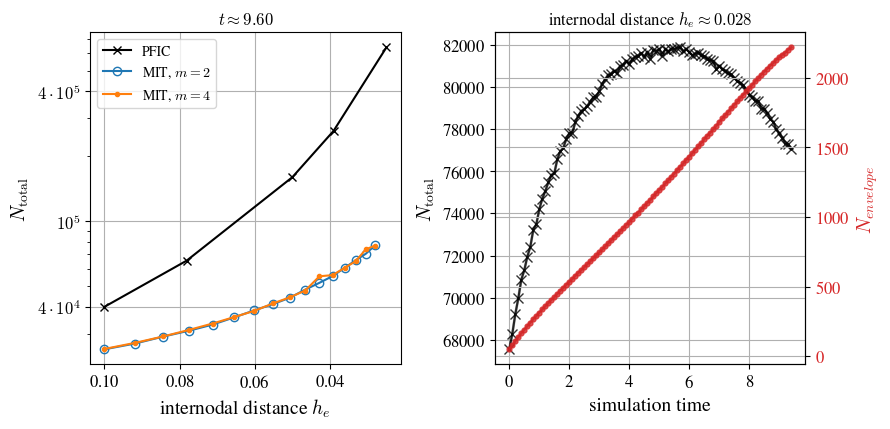

In [117]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4.4))

min_time = np.min(simulation_times)
max_time = np.max(simulation_times)
avg_time = (max_time + min_time) * 0.5
times_sim = [9.6]


files = [glob.glob("../data/spline2/spline2_results_*.h5"), glob.glob("../data/high_order/spline2_mon_4_*.h5")]

for id, source_files in enumerate(files):

    hs = []
    simulation_times = []
    for source_file in source_files:
        print("Reading: ", source_file)
        data = h5.File(source_file, 'r')
        hs.append(data['conf'].attrs.get('domain.dendrite.h'))
        groups = list(data.keys())
        for group in groups:
            if "step" not in group:
                continue
            simulation_times.append(data[group].attrs['time'])
        data.close()

    hs = sorted(hs)


    min_time = np.min(simulation_times)
    max_time = np.max(simulation_times)
    avg_time = (max_time + min_time) * 0.5
    times_sim = [9.6]

    data_p = {}

    for source_file in source_files:
        data = h5.File(source_file, 'r')

        # Get groups.
        groups = list(data.keys())
        positions = []
        velocities = []
        times = []
        types = []
        for group in groups:
            if "step" not in group:
                continue

            positions.append(data[group]['domain']['pos'][:])
            velocities.append(data[group].attrs['max_tip_velocity'])
            times.append(data[group].attrs['time'])
            types.append(data[group]['domain']['types'][:])

        # Conf.
        dendrite_h = data['conf'].attrs.get('domain.dendrite.h')

        # Close.
        data.close()

        # Set time step.
        for time in times_sim:
            temp_data = {}
            closest_time = min(times, key=lambda x: abs(x-time))
            idx = times.index(closest_time)
            pos = positions[idx]

            # Extract only dendrite boundary. Only one quarter please.
            envelope_position_idx = [i for i in range(len(types[idx])) if (
                types[idx][i] == -2)]
            envelope_positions = pos[:, envelope_position_idx]

            temp_data['max_position'] = np.max(envelope_positions)
            temp_data['goal_time'] = time
            temp_data['closest_time'] = closest_time
            temp_data['N_envelope'] = len(envelope_positions[0])
            temp_data['N_total'] = len(pos[0])
            temp_data['h'] = dendrite_h
            data_p['{}_{}'.format(source_file, time)] = temp_data

    times = [data_p[id]['goal_time'] for id in data_p]
    unique_times = np.unique(times)
    print(unique_times)
    fvm_times = ['9.7']


    # FVM
    files = glob.glob('../data/FVM/surfaces/*' + os.path.sep)
    max_fvm_pos = []
    fvm_hs = []
    fvm_total_nodes = []
    for time in fvm_times:
        max_pos = []
        temp_hs = []
        nodes = []
        for file in files[:-1]:
            temp_hs.append(float(file.split('_m')[-1].split('/')[0]))
            filepath = '{}postProcessing/surfaces/{}/alpha1_interpolatedIso.raw'.format(file,time)
            with open(filepath) as f:
                lines = f.readlines()

            #  Parse data from file.
            x = []
            y = []
            for line in lines[2:]:
                val = line.strip().split(' ')
                x.append(float(val[0]))
                y.append(float(val[1]))
            max_pos.append(max(np.max(x), np.max(y)))
            nodes.append(len(x))

        max_fvm_pos.append(max_pos)
        fvm_hs.append(temp_hs)
        fvm_total_nodes.append(nodes)

    # TOTAL NODES
    axs[0].set_title(r'$t \approx {:.2f}$'.format(unique_times[0]))

    for color_id, time in enumerate(unique_times):
        # FVM
        if id == 0:
            fvm_x, fvm_y = zip(*sorted(zip(fvm_hs[color_id],[(20/x)**2 for x in fvm_hs[color_id]] )))
            axs[0].semilogy(fvm_x[:-2], fvm_y[:-2], 'x-k', label='PFIC')

            axs[0].invert_xaxis()
        nodes_tot = [data_p[id]['N_total']
                for id in data_p if (data_p[id]['goal_time'] == time)]
        internodal_distances = [data_p[id]['h']
                                for id in data_p if (data_p[id]['goal_time'] == time)]

        # sort by nodes.
        internodal_distances, nodes_tot = zip(*sorted(zip(internodal_distances, nodes_tot)))

        if id == 0:
            axs[0].semilogy(internodal_distances[-16:], nodes_tot[-16:], '-',label="MIT," + (" $m=2$" if id == 0 else " $m=4$"),  marker='o', fillstyle='none')
        else:
            axs[0].semilogy(internodal_distances[-16:], nodes_tot[-16:], '.-', label="MIT," + (" $m=2$" if id == 0 else " $m=4$"))

        axs[0].grid(True)
        axs[0].set_xlabel('internodal distance $h_e$')
        axs[0].set_ylabel('$N_\mathrm{total}$')
        axs[0].legend(loc='upper left')


ticks = [4e4, 1e5, 4e5]
labels = ['$4\cdot 10^4$', '$10^5$', '$4\cdot 10^5$']
axs[0].set_yticks(ticks)
axs[0].set_yticklabels(labels)


h = hs[0]  # largest domain.
axs[1].set_title("internodal distance $h_e \\approx {:.3f}$".format(h))
for source_file in source_files:
    data = h5.File(source_file, 'r')

    if (data['conf'].attrs.get('domain.dendrite.h') != h):
        data.close()
        continue

    # Get groups.
    groups = list(data.keys())
    nodes = []
    envelope_nodes = []
    times = []
    for group in groups:
        if "step" not in group:
            continue

        pos = data[group]['domain']['pos'][:]
        nodes.append(len(pos[0]))
        types = data[group]['domain']['types'][:]
        envelope_nodes.append(len(pos[0, types == -2]))
        times.append(data[group].attrs['time'])

    # Close file.
    data.close()

    # Plot total nodes.
    axs[1].plot(times, nodes, color='k', alpha=0.3, lw=2)
    axs[1].plot(times, nodes, marker='x', color='k', alpha=0.8, ms=7)
    axs[1].set_xlabel(r'simulation time')
    axs[1].set_ylabel(r'$N_\mathrm{total}$')
    axs[1].grid("both")

    # Plot envelope nodes.
    axs[1] = axs[1].twinx()
    axs[1].plot(times, envelope_nodes, color='k', alpha=0.3, lw=2)
    axs[1].plot(times, envelope_nodes, marker='.',
            color='tab:red', alpha=0.8, ms=7)
    axs[1].grid("both")
    axs[1].set_ylabel(r'$N_{envelope}$', color='tab:red')
    axs[1].tick_params(axis='y', labelcolor='tab:red')

    axs[1] = ax.twiny()
    axs[1].set_xlabel(r'$h_e\approx {:.2}$'.format(h))
    axs[1].set_xticklabels([])
    axs[1].set_xticks([])

fig.tight_layout()

if 1:
    fig.savefig('../manuscript/paper/figures/nodes.eps', dpi=300, transparent=False, bbox_inches='tight')


<>:140: DeprecationWarning: invalid escape sequence '\m'
<>:145: DeprecationWarning: invalid escape sequence '\c'
<>:145: DeprecationWarning: invalid escape sequence '\c'
<>:140: DeprecationWarning: invalid escape sequence '\m'
<>:145: DeprecationWarning: invalid escape sequence '\c'
<>:145: DeprecationWarning: invalid escape sequence '\c'
/tmp/ipykernel_42699/1676684299.py:140: DeprecationWarning: invalid escape sequence '\m'
  axs.set_ylabel('$N_\mathrm{total}$')
/tmp/ipykernel_42699/1676684299.py:145: DeprecationWarning: invalid escape sequence '\c'
  labels = ['$4\cdot 10^4$', '$10^5$', '$4\cdot 10^5$']
/tmp/ipykernel_42699/1676684299.py:145: DeprecationWarning: invalid escape sequence '\c'
  labels = ['$4\cdot 10^4$', '$10^5$', '$4\cdot 10^5$']


Reading:  ../data/spline2/spline2_results_000001.h5
Reading:  ../data/spline2/spline2_results_000000.h5
Reading:  ../data/spline2/spline2_results_000011.h5
Reading:  ../data/spline2/spline2_results_000006.h5
Reading:  ../data/spline2/spline2_results_000016.h5
Reading:  ../data/spline2/spline2_results_000009.h5
Reading:  ../data/spline2/spline2_results_000007.h5
Reading:  ../data/spline2/spline2_results_000002.h5
Reading:  ../data/spline2/spline2_results_000003.h5
Reading:  ../data/spline2/spline2_results_000005.h5
Reading:  ../data/spline2/spline2_results_000004.h5
Reading:  ../data/spline2/spline2_results_000015.h5
Reading:  ../data/spline2/spline2_results_000014.h5
Reading:  ../data/spline2/spline2_results_000008.h5
Reading:  ../data/spline2/spline2_results_000010.h5
Reading:  ../data/spline2/spline2_results_000013.h5
Reading:  ../data/spline2/spline2_results_000012.h5
[9.6]
Reading:  ../data/high_order/spline2_mon_4_results_000005.h5
Reading:  ../data/high_order/spline2_mon_4_result

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


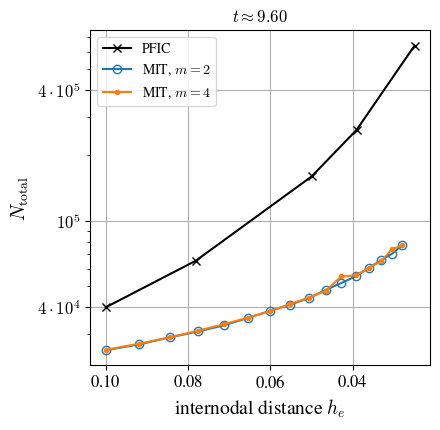

In [118]:
fig, axs = plt.subplots(1, 1, figsize=(4.5, 4.4))

min_time = np.min(simulation_times)
max_time = np.max(simulation_times)
avg_time = (max_time + min_time) * 0.5
times_sim = [9.6]


files = [glob.glob("../data/spline2/spline2_results_*.h5"), glob.glob("../data/high_order/spline2_mon_4_*.h5")]

for id, source_files in enumerate(files):

    hs = []
    simulation_times = []
    for source_file in source_files:
        print("Reading: ", source_file)
        data = h5.File(source_file, 'r')
        hs.append(data['conf'].attrs.get('domain.dendrite.h'))
        groups = list(data.keys())
        for group in groups:
            if "step" not in group:
                continue
            simulation_times.append(data[group].attrs['time'])
        data.close()

    hs = sorted(hs)


    min_time = np.min(simulation_times)
    max_time = np.max(simulation_times)
    avg_time = (max_time + min_time) * 0.5
    times_sim = [9.6]

    data_p = {}

    for source_file in source_files:
        data = h5.File(source_file, 'r')

        # Get groups.
        groups = list(data.keys())
        positions = []
        velocities = []
        times = []
        types = []
        for group in groups:
            if "step" not in group:
                continue

            positions.append(data[group]['domain']['pos'][:])
            velocities.append(data[group].attrs['max_tip_velocity'])
            times.append(data[group].attrs['time'])
            types.append(data[group]['domain']['types'][:])

        # Conf.
        dendrite_h = data['conf'].attrs.get('domain.dendrite.h')

        # Close.
        data.close()

        # Set time step.
        for time in times_sim:
            temp_data = {}
            closest_time = min(times, key=lambda x: abs(x-time))
            idx = times.index(closest_time)
            pos = positions[idx]

            # Extract only dendrite boundary. Only one quarter please.
            envelope_position_idx = [i for i in range(len(types[idx])) if (
                types[idx][i] == -2)]
            envelope_positions = pos[:, envelope_position_idx]

            temp_data['max_position'] = np.max(envelope_positions)
            temp_data['goal_time'] = time
            temp_data['closest_time'] = closest_time
            temp_data['N_envelope'] = len(envelope_positions[0])
            temp_data['N_total'] = len(pos[0])
            temp_data['h'] = dendrite_h
            data_p['{}_{}'.format(source_file, time)] = temp_data

    times = [data_p[id]['goal_time'] for id in data_p]
    unique_times = np.unique(times)
    print(unique_times)
    fvm_times = ['9.7']


    # FVM
    files = glob.glob('../data/FVM/surfaces/*' + os.path.sep)
    max_fvm_pos = []
    fvm_hs = []
    fvm_total_nodes = []
    for time in fvm_times:
        max_pos = []
        temp_hs = []
        nodes = []
        for file in files[:-1]:
            temp_hs.append(float(file.split('_m')[-1].split('/')[0]))
            filepath = '{}postProcessing/surfaces/{}/alpha1_interpolatedIso.raw'.format(file,time)
            with open(filepath) as f:
                lines = f.readlines()

            #  Parse data from file.
            x = []
            y = []
            for line in lines[2:]:
                val = line.strip().split(' ')
                x.append(float(val[0]))
                y.append(float(val[1]))
            max_pos.append(max(np.max(x), np.max(y)))
            nodes.append(len(x))

        max_fvm_pos.append(max_pos)
        fvm_hs.append(temp_hs)
        fvm_total_nodes.append(nodes)

    # TOTAL NODES
    axs.set_title(r'$t \approx {:.2f}$'.format(unique_times[0]))

    for color_id, time in enumerate(unique_times):
        # FVM
        if id == 0:
            fvm_x, fvm_y = zip(*sorted(zip(fvm_hs[color_id],[(20/x)**2 for x in fvm_hs[color_id]] )))
            axs.semilogy(fvm_x[:-2], fvm_y[:-2], 'x-k', label='PFIC')

            axs.invert_xaxis()
        nodes_tot = [data_p[id]['N_total']
                for id in data_p if (data_p[id]['goal_time'] == time)]
        internodal_distances = [data_p[id]['h']
                                for id in data_p if (data_p[id]['goal_time'] == time)]

        # sort by nodes.
        internodal_distances, nodes_tot = zip(*sorted(zip(internodal_distances, nodes_tot)))

        if id == 0:
            axs.semilogy(internodal_distances[-16:], nodes_tot[-16:], '-',label="MIT," + (" $m=2$" if id == 0 else " $m=4$"),  marker='o', fillstyle='none')
        else:
            axs.semilogy(internodal_distances[-16:], nodes_tot[-16:], '.-', label="MIT," + (" $m=2$" if id == 0 else " $m=4$"))

        axs.grid(True)
        axs.set_xlabel('internodal distance $h_e$')
        axs.set_ylabel('$N_\mathrm{total}$')
        axs.legend(loc='upper left')


ticks = [4e4, 1e5, 4e5]
labels = ['$4\cdot 10^4$', '$10^5$', '$4\cdot 10^5$']
axs.set_yticks(ticks)
axs.set_yticklabels(labels)


fig.tight_layout()

if 1:
    fig.savefig('../manuscript/paper/figures/conv_at_time.eps', dpi=300, transparent=False, bbox_inches='tight')


Reading:  ../data/spline2/spline2_results_000001.h5
Reading:  ../data/spline2/spline2_results_000000.h5
Reading:  ../data/spline2/spline2_results_000011.h5
Reading:  ../data/spline2/spline2_results_000006.h5
Reading:  ../data/spline2/spline2_results_000016.h5
Reading:  ../data/spline2/spline2_results_000009.h5
Reading:  ../data/spline2/spline2_results_000007.h5
Reading:  ../data/spline2/spline2_results_000002.h5
Reading:  ../data/spline2/spline2_results_000003.h5
Reading:  ../data/spline2/spline2_results_000005.h5
Reading:  ../data/spline2/spline2_results_000004.h5
Reading:  ../data/spline2/spline2_results_000015.h5
Reading:  ../data/spline2/spline2_results_000014.h5
Reading:  ../data/spline2/spline2_results_000008.h5
Reading:  ../data/spline2/spline2_results_000010.h5
Reading:  ../data/spline2/spline2_results_000013.h5
Reading:  ../data/spline2/spline2_results_000012.h5
[9.696]
Reading:  ../data/high_order/spline2_mon_4_results_000005.h5
Reading:  ../data/high_order/spline2_mon_4_resu

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


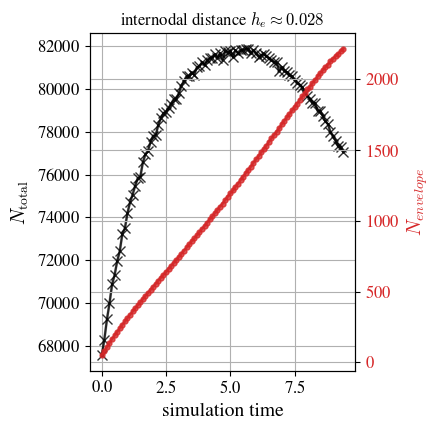

In [24]:
fig, axs = plt.subplots(1, 1, figsize=(4.5, 4.4))

min_time = np.min(simulation_times)
max_time = np.max(simulation_times)
avg_time = (max_time + min_time) * 0.5
times_sim = [max_time * 0.96]


files = [glob.glob("../data/spline2/spline2_results_*.h5"), glob.glob("../data/high_order/spline2_mon_4_*.h5")]

for id, source_files in enumerate(files):

    hs = []
    simulation_times = []
    for source_file in source_files:
        print("Reading: ", source_file)
        data = h5.File(source_file, 'r')
        hs.append(data['conf'].attrs.get('domain.dendrite.h'))
        groups = list(data.keys())
        for group in groups:
            if "step" not in group:
                continue
            simulation_times.append(data[group].attrs['time'])
        data.close()

    hs = sorted(hs)


    min_time = np.min(simulation_times)
    max_time = np.max(simulation_times)
    avg_time = (max_time + min_time) * 0.5
    times_sim = [max_time * 0.96]

    data_p = {}

    for source_file in source_files:
        data = h5.File(source_file, 'r')

        # Get groups.
        groups = list(data.keys())
        positions = []
        velocities = []
        times = []
        types = []
        for group in groups:
            if "step" not in group:
                continue

            positions.append(data[group]['domain']['pos'][:])
            velocities.append(data[group].attrs['max_tip_velocity'])
            times.append(data[group].attrs['time'])
            types.append(data[group]['domain']['types'][:])

        # Conf.
        dendrite_h = data['conf'].attrs.get('domain.dendrite.h')

        # Close.
        data.close()

        # Set time step.
        for time in times_sim:
            temp_data = {}
            closest_time = min(times, key=lambda x: abs(x-time))
            idx = times.index(closest_time)
            pos = positions[idx]

            # Extract only dendrite boundary. Only one quarter please.
            envelope_position_idx = [i for i in range(len(types[idx])) if (
                types[idx][i] == -2)]
            envelope_positions = pos[:, envelope_position_idx]

            temp_data['max_position'] = np.max(envelope_positions)
            temp_data['goal_time'] = time
            temp_data['closest_time'] = closest_time
            temp_data['N_envelope'] = len(envelope_positions[0])
            temp_data['N_total'] = len(pos[0])
            temp_data['h'] = dendrite_h
            data_p['{}_{}'.format(source_file, time)] = temp_data

    times = [data_p[id]['goal_time'] for id in data_p]
    unique_times = np.unique(times)
    print(unique_times)
    fvm_times = ['9.7']


    # FVM
    files = glob.glob('../data/FVM/surfaces/*' + os.path.sep)
    max_fvm_pos = []
    fvm_hs = []
    fvm_total_nodes = []
    for time in fvm_times:
        max_pos = []
        temp_hs = []
        nodes = []
        for file in files[:-1]:
            temp_hs.append(float(file.split('_m')[-1].split('/')[0]))
            filepath = '{}postProcessing/surfaces/{}/alpha1_interpolatedIso.raw'.format(file,time)
            with open(filepath) as f:
                lines = f.readlines()

            #  Parse data from file.
            x = []
            y = []
            for line in lines[2:]:
                val = line.strip().split(' ')
                x.append(float(val[0]))
                y.append(float(val[1]))
            max_pos.append(max(np.max(x), np.max(y)))
            nodes.append(len(x))

        max_fvm_pos.append(max_pos)
        fvm_hs.append(temp_hs)
        fvm_total_nodes.append(nodes)


h = hs[0]  # largest domain.
axs.set_title("internodal distance $h_e \\approx {:.3f}$".format(h))
for source_file in source_files:
    data = h5.File(source_file, 'r')

    if (data['conf'].attrs.get('domain.dendrite.h') != h):
        data.close()
        continue

    # Get groups.
    groups = list(data.keys())
    nodes = []
    envelope_nodes = []
    times = []
    for group in groups:
        if "step" not in group:
            continue

        pos = data[group]['domain']['pos'][:]
        nodes.append(len(pos[0]))
        types = data[group]['domain']['types'][:]
        envelope_nodes.append(len(pos[0, types == -2]))
        times.append(data[group].attrs['time'])

    # Close file.
    data.close()

    # Plot total nodes.
    axs.plot(times, nodes, color='k', alpha=0.3, lw=2)
    axs.plot(times, nodes, marker='x', color='k', alpha=0.8, ms=7)
    axs.set_xlabel(r'simulation time')
    axs.set_ylabel(r'$N_\mathrm{total}$')
    axs.grid("both")

    # Plot envelope nodes.
    axs = axs.twinx()
    axs.plot(times, envelope_nodes, color='k', alpha=0.3, lw=2)
    axs.plot(times, envelope_nodes, marker='.',
            color='tab:red', alpha=0.8, ms=7)
    axs.grid("both")
    axs.set_ylabel(r'$N_{envelope}$', color='tab:red')
    axs.tick_params(axis='y', labelcolor='tab:red')

    axs = ax.twiny()
    axs.set_xlabel(r'$h_e\approx {:.2}$'.format(h))
    axs.set_xticklabels([])
    axs.set_xticks([])

fig.tight_layout()

if 1:
    fig.savefig('../manuscript/paper/figures/conv_at_h.eps', dpi=300, transparent=False, bbox_inches='tight')
